# Sections

- [Read data](#read_data)
    * [Read counts data](#read_counts_data)
    * [Read Mid-probability table](#read_Mid-probability_table)
- [Hypothesis I](#hypothesis1)
- [Hypothesis III](#hypothesis3)
    * [Reproduce results](#reproduce_results_hypothesis3)
    * [Test for individuals in the lab](#individuals_hypothesis3)

- [Permutation test](#permutation_test)

    * [Terminal digit analysis](#terminal_digit_analysis)
    * [Equal digit analysis](#equal_digit_analysis)
- [Tables and figures](#tablesFigures)
    * [Table 1](#table1)
    * [Figure 1](#figure1)
    * [Poisson test](#Poisson_test)


In [1]:
from __future__ import division, generators, absolute_import, print_function

import numpy as np
import scipy.stats
import pandas as pd
import random
import matplotlib.pyplot as plt

data_dir = '../data/'

<a id='read_data'></a>
# Read Data

<a id='read_counts_data'></a>
## Read counts data

In [226]:
def read_data(data_dir, file_name, skiprows, triple_col):
    """
    This function reads data from xlsx file
    
    Parameters
    ----------
        data_dir: string
            data directory
        file_name: string
            xlsx file name
        skiprows: int
            rows to skip at the beginning
        triple_col: list of string
            a list of length 3, the column name for the triple in the xlsx file
    
    Returns
    -------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    """
    df = pd.read_excel(data_dir + file_name, skiprows = skiprows)
    df[triple_col] = df[triple_col].apply(
        lambda x: pd.to_numeric(x, errors='coerce'))
    col_name = ['col1', 'col2', 'col3']
    df = df.rename(columns = {triple_col[0]: col_name[0],
                              triple_col[1]: col_name[1],
                              triple_col[2]: col_name[2]})
    return df

In [1]:
def filter_na_triple(df):
    """
    This function remove triples with missing values
    
    Parameters
    ----------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    
    Returns
    -------   
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            triples with missing values are removed
    """
    df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    nan_index = df[col_name].apply(np.isnan).any(1).nonzero()[0]
    df = df.drop(df.index[nan_index])
    df = df.reset_index(drop=True) 
    return df

In [2]:
def filter_gap_2(df):
    """
    This function sort each triple by increasing order, and 
    triples with gap less than or equal to 1 are filtered out
    
    Parameters
    ----------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    
    Returns
    -------   
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            each triple is sorted by increasing order,
            triples with gap less than or equal to 1 are filtered out
    """
    
    df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    nan_index = df[col_name].apply(np.isnan).any(1).nonzero()[0]
    df = df.drop(df.index[nan_index])
    df = df.reset_index(drop=True)
    
    # sort each triple by increasing order
    df[col_name] = df[col_name].apply(np.sort, axis = 1)
    
    # filter out the triples with gap less than or equal to 1
    complete_index = df[col_name].apply(
        lambda x: x.col3 - x.col1 <=1, axis=1).nonzero()[0]
    df = df.drop(df.index[complete_index])
    df = df.reset_index(drop=True)
    
    return df

<a id='readfromxls'></a>

In [9]:
def ReadFromXls(file, cols, rows, types, sorted = True, verbose = True):
    '''
     Read file.xlsx and extract a 2d list 
     Written by BigRabbit.
     Inputs:
       file    : str of file location
       cols    : list/tuple of selected columns
       rows    : list/tuple of selected rows
       types   : a tuple of allowed types, e.g. (int, long)
       sorted  : boolean whether to sort each row (only valid when types are numerics)
       verbose : boolean whether to print what's going on
     Output:
       a 2d list of integers
    '''
    if verbose: print('****** ReadFromXls: Read file.xlsx and extract a 2d list *****')
    from openpyxl import load_workbook
    wb  = load_workbook(file) 
    if verbose: print('-- Opened file:', file)
    if verbose: print('-- Sheet names:', wb.get_sheet_names(), 'Using Sheet1 as default.')
    ws = wb.get_sheet_by_name('Sheet1')
    if verbose: print('-- A1 (typically the title):', ws['A1'].value)
    rawData = []
    for i in rows:
        oneRow = []
        for j in cols:
            entry = ws[j + str(i)].value
            if isinstance(entry, types):
                oneRow.append(entry)
            else:
                break
        if len(oneRow) == len(cols):
            if sorted: oneRow.sort()
            rawData.append(oneRow)
    if verbose: print('-- successfully read ', len(rawData), 'full lines!')
    if verbose: print('************************ finished. *************************')
    return rawData

In [229]:
# colony data: RTS
rts_colony = read_data(
    data_dir, 'Bishayee Colony Counts 10.27.97-3.8.01.xlsx', 
    skiprows=2, triple_col=['col1', 'col2', 'col3'])

# colony data: other invectigators in the lab
inv_colony = read_data(
    data_dir, 'Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx', 
    skiprows=1, triple_col=['col1', 'col2', 'col3'])

# colony data: outside lab
lab_colony = read_data(
    data_dir, 'Outside Lab 3.Colony Counts.2.4.10-5.21.12.xlsx', 
    skiprows=1, triple_col=['c1', 'c2', 'c3'])

In [230]:
# coulter data: RTS
rts_coulter = read_data(
    data_dir, 'Bishayee Coulter Counts.10.20.97-7.16.01.xlsx', 
    skiprows=1, triple_col=['Count 1', 'Count 2', 'Count 3'])

# coulter data: other invectigators in the lab
inv_coulter = read_data(
    data_dir, 'Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx', 
    skiprows=1, triple_col=['Coul 1', 'Coul 2', 'Coul 3'])

# coulter data: outside lab1
lab1_coulter = read_data(
    data_dir, 'Outside Lab 1.Coulter Counts.6.7.91-4.9.99.xlsx', 
    skiprows=0, triple_col=['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'])

# coulter data: outside lab2
lab2_coulter = read_data(
    data_dir, 'Outside Lab 2.Coulter Counts.6.6.08-7.7.08.xlsx', 
    skiprows=1, triple_col=['Count 1', 'Count 2', 'Count 3'])

In [231]:
no_triples = pd.DataFrame(columns=("No. triples", "No. complete"))
for dfs in ["rts_colony", "inv_colony", "lab_colony",
            "rts_coulter", "inv_coulter", "lab1_coulter", "lab2_coulter"]:
    no_triples.loc[dfs] = (len(filter_na_triple(eval(dfs))), 
                           len(filter_gap_2(eval(dfs))))
no_triples

,No. triples,No. complete
rts_colony,1361.0,1343.0
inv_colony,597.0,578.0
lab_colony,50.0,49.0
rts_coulter,1727.0,1726.0
inv_coulter,929.0,929.0
lab1_coulter,97.0,97.0
lab2_coulter,120.0,120.0


<a id='read_Mid-probability_table'></a>
## Read Mid-probability table

In [232]:
# read the mid probability table from output directory
# mid probability table: the mid-containing probability for different 
# values of lambdas
output_dir = "../outputs/"
midProb = np.loadtxt(output_dir + "MidProb.txt", delimiter="\t")
midProb.shape

(2129, 2)

<a id='hypothesis1'></a>
# Hypothesis I
require read data function [ReadFromXls](#readfromxls)

In [46]:
from scipy.stats import binom
file = '../data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx'
rawData2 = ReadFromXls(file, ('C', 'D', 'E', 'F'), rows = range(3, 623), types = (int, str), sorted = False, verbose=False)
invs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
test1 = pd.DataFrame(columns = ('No. Obs.', 'No. Mid', 'p-value Upper bound'))
test1.loc['RTS']  = ('%d' % 1343, '%d' %  690, '%.2e' % (1 - binom.cdf(690 - 1, 1343, 0.42)))
test1.loc['Else'] = ('%d' % 572, '%d' % 109, '%.2e' % (1 - binom.cdf(109 - 1,  572, 0.42)))
for name in invs:
    data = [x[1:4] for x in rawData2 if x[0] == name]
    data = [x for x in data if isinstance(x[0], int) and isinstance(x[1], int) and isinstance(x[2], int)] # filter out empty
    data = [np.sort(x) for x in data] # sort each row from small to big
    data = [x for x in data if x[2] - x[0] > 1] # filter out gap < 2
    containMean = [x for x in data if int((x[0] + x[1] + x[2])/3) == int(x[1])]
    test1.loc[name] = ('%d' % len(data), '%d' % len(containMean), '%.2e' % (1 - binom.cdf(len(containMean) - 1, len(data), .42)))
test1

,No. Obs.,No. Mid,p-value Upper bound
RTS,1343,690,2.85e-12
Else,572,109,1.00e+00
A,248,47,1.00e+00
B,56,8,1.00e+00
C,85,20,1.00e+00
D,77,11,1.00e+00
E,10,1,9.96e-01
F,29,3,1.00e+00
G,7,1,9.78e-01
H,21,0,1.00e+00


<a id='hypothesis3'></a>
# Hypothesis III

In [248]:
def hypothesis_3(df, midProb, print_res=False):
    """
    This function implements the hypothesis test 3 for mean-containing 
    ratio in the paper.
    
    Parameters
    ----------
        filtered_df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            each triple is sorted by increasing order,
            triples with gap less than or equal to 1 are filtered out
        midProb: numpy.ndarray
            mid probability table, the mid-containing probability for 
            different values of lambdas
        print_res: default False
            False: print all the results
            True: return number of mean containing triples, mean and sd
                of poission binomial, Z statistic and p-value without printing
    """
    filtered_df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    
    # sort each triple by increasing order
    filtered_df[col_name] = filtered_df[col_name].apply(np.sort, axis = 1)
    
    # whether the mid number is the mean of largest and smallest
    isMid = filtered_df.apply(
        lambda x: x.col1 + x.col3 in [2*x.col2, 2*x.col2 + 1, 2*x.col2 - 1], axis=1)
    
    # rounded mean triple as the estimate of lambda
    lamEst = np.mean(filtered_df[col_name], axis=1)
    # probabiliy that the triple been randomly drawn it would contain its own mean
    lams = np.array([i[0] for i in midProb])
    probs = [midProb[np.argmin(abs(lams-i))][1] for i in lamEst]
    
    # expectation and variance of poisson binomial
    mu = np.sum(probs)
    sigma2 = np.sum(p*(1-p) for p in probs)
    
    # compute statistic and p-value for hypothesis 3
    stat3 = (sum(isMid) - 0.5 - mu) / np.sqrt(sigma2)
    p_value3 = 1 - scipy.stats.norm.cdf(stat3)
    
    if print_res:
        print("Number of mean containing triples: ", sum(isMid))
        print("Mean of poission binomial: ", mu)
        print("SD of poission binomial: ", np.sqrt(sigma2))
        print("Z statistic: ", stat3)
        print("p-value: ", p_value3)
    else:
        return len(filtered_df), sum(isMid), mu, np.sqrt(sigma2), stat3, p_value3

<a id='reproduce_results_hypothesis3'></a>
## Reproduce results

In [249]:
hypothesis_3_res = pd.DataFrame(columns=('No. complete', 'No. mean containing', 
                                         'No.expected', "sd", "Z", "p-value"))
for dfs in ["filtered_rts_colony", "filtered_inv_colony", "filtered_lab_colony",
            "filtered_rts_coulter", "filtered_inv_coulter", 
            "filtered_lab1_coulter", "filtered_lab2_coulter"]:
    hypothesis_3_res.loc[dfs] = hypothesis_3(filter_gap_2(eval(dfs)), midProb)
hypothesis_3_res

,No. complete,No. mean containing,No.expected,sd,Z,p-value
filtered_rts_colony,1343.0,690.0,214.923602,13.281792,35.731353,0.000000e+00
filtered_inv_colony,578.0,109.0,103.404567,9.061666,0.562306,2.869536e-01
filtered_lab_colony,49.0,3.0,7.788269,2.554401,-2.070258,9.807859e-01
filtered_rts_coulter,1726.0,176.0,98.367748,9.612620,8.024061,5.551115e-16
filtered_inv_coulter,929.0,36.0,39.851416,6.107390,-0.712484,7.619174e-01
filtered_lab1_coulter,97.0,0.0,4.430351,2.033995,-2.423974,9.923241e-01
filtered_lab2_coulter,120.0,1.0,3.752921,1.897438,-1.714375,9.567701e-01


In [250]:
hypothesis_3(filter_na_triple(rts_colony), midProb, print_res=True)

Number of mean containing triples:  708
Mean of poission binomial:  220.313684239
SD of poission binomial:  13.4181445464
Z statistic:  36.3080241145
p-value:  0.0


In [251]:
hypothesis_3(filter_na_triple(inv_colony), midProb, print_res=True)

Number of mean containing triples:  128
Mean of poission binomial:  108.501276257
SD of poission binomial:  9.25874114803
Z statistic:  2.05197698475
p-value:  0.0200859495977


<a id='individuals_hypothesis3'></a>
## Test for individuals in the lab

In [252]:
hypothesis_3_ind = pd.DataFrame(columns=('No. complete', 'No. mean containing', 
                                         'No.expected', "sd", "Z", "p-value"))
for inv in set(filtered_inv_colony.Inv):
    hypothesis_3_ind.loc[inv] = hypothesis_3(
        filtered_inv_colony.loc[filtered_inv_colony.Inv == inv].copy(), midProb)
hypothesis_3_ind

,No. complete,No. mean containing,No.expected,sd,Z,p-value
H,21.0,1.0,2.827193,1.554125,-1.497429,0.932859
I,44.0,8.0,7.818411,2.480351,-0.128373,0.551073
E,10.0,2.0,1.306389,1.059426,0.182751,0.427497
B,56.0,8.0,9.622682,2.790427,-0.760701,0.776582
G,8.0,4.0,1.829225,1.179072,1.417026,0.078238
F,29.0,6.0,5.139362,2.020507,0.178489,0.429169
C,85.0,25.0,17.189069,3.656139,1.999632,0.022770
D,77.0,13.0,13.584431,3.323176,-0.326324,0.627910
A,248.0,42.0,44.087806,5.895250,-0.438965,0.669656


<a id='permutation_test'></a>
# Permutation test

<a id='terminal_digit_analysis'></a>
## Terminal digit analysis

In [183]:
def calc_distance(group1, group2):
    """
    This function calculate the distance between group1 and group2 using 
    Chi-squared distance and Total Variation Distance (tvd).
    
    Parameters
    ----------
        group1: list
            terminal digit list, which contains integers 0-9
        group2: list
            terminal digit list, which contains integers 0-9
    
    Returns
    -------
        tvd_obs: float
            Total Variation Distance
        chi_sq_obs: float
            Chi-squared distance
    """
    group1_obs = [group1.count(i)/len(group1) for i in range(10)]
    group2_obs = [group2.count(i)/len(group2) for i in range(10)]
    tvd_obs = 0.5*sum([abs(a_i - b_i) 
                       for a_i, b_i in zip(group1_obs, group2_obs)])
    chi_sq_obs = 0.5*sum([abs(a_i - b_i)**2/(a_i + b_i) 
                          for a_i, b_i in zip(group1_obs, group2_obs)])
    return tvd_obs, chi_sq_obs

In [255]:
def terminal_permutation(group1, group2, replication, plot = False):
    """
    This function apply permutation test on the terminal digits for two groups.
    The distance between two distribution are measured using Chi-squared distance 
    and Total Variation Distance (tvd).
    
    Parameters
    ----------
        group1, group2: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
        replication: int
            replication times for permutation
        plot:
            if True, plot the histogram of permutated statitics and 
            observed statitics
    
    Returns
    -------
        tvd_obs: float
            observed tvd
        tvd_p_value:  float
            p-value calculated using tvd
        chi_sq_obs: float
            observed chi square distance
        chi_sq_p_value:  float
            p-value calculated using chi square distance
    """
    # obtain the terminal digits
    group1 = group1[['col1', 'col2', 'col3']].values.flatten()
    group1 = group1[~np.isnan(group1)]
    group1 = [np.mod(i, 10) for i in group1]
    group2 = group2[['col1', 'col2', 'col3']].values.flatten()
    group2 = group2[~np.isnan(group2)]
    group2 = [np.mod(i, 10) for i in group2]
    
    # observed distance between distribution
    tvd_obs, chi_sq_obs = calc_distance(group1, group2)
    
    # permutation
    tvd = []
    chi_sq = []
    for i in np.arange(replication):
        shuffled = random.sample(group1 + group2, 
                                 len(group1 + group2))
        tvd_shuffled, chi_sq_shuffled = calc_distance(shuffled[:len(group1)], 
                                                      shuffled[len(group1):])
        tvd.append(tvd_shuffled)
        chi_sq.append(chi_sq_shuffled)
        
    tvd_p_value = sum(np.array(tvd) > tvd_obs) / replication
    chi_sq_p_value = sum(np.array(chi_sq) > chi_sq_obs) / replication
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
        ax1.hist(tvd, bins=20, color='c')
        ax1.axvline(tvd_obs, color='b', linestyle='dashed', linewidth=2)
        ax1.set_title("TVD")
        ax2.hist(chi_sq, bins=20, color='c')
        ax2.axvline(chi_sq_obs, color='b', linestyle='dashed', linewidth=2)
        ax2.set_title("Chi squared distance")
        plt.show()
        
    return tvd_obs, tvd_p_value, chi_sq_obs, chi_sq_p_value

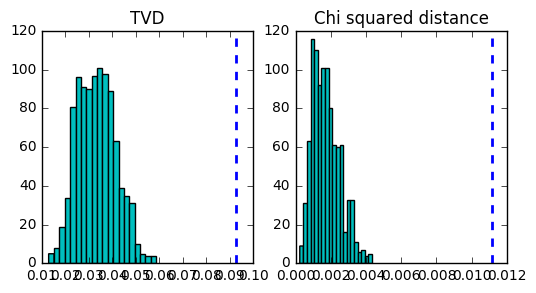

(0.09260466984966408, 0.0, 0.011145925839597975, 0.0)

In [256]:
terminal_permutation(rts_colony, inv_colony, replication=1000, plot=True)

In [257]:
colony_terminal_permute = pd.DataFrame(
    columns=('tvd obs', "tvd p-value", 
             "chi sq obs", "chi sq p-value"))
for inv in set(inv_colony.Inv):
    colony_terminal_permute.loc[inv] = terminal_permutation(
        inv_colony.loc[inv_colony.Inv == inv], 
        inv_colony.loc[inv_colony.Inv != inv], 
        replication=1000)
colony_terminal_permute

,tvd obs,tvd p-value,chi sq obs,chi sq p-value
H,0.210741,0.073,0.063945,0.091
I,0.100714,0.513,0.012008,0.694
E,0.176644,0.762,0.048531,0.840
B,0.126554,0.099,0.024279,0.081
G,0.234996,0.417,0.101799,0.299
F,0.113749,0.658,0.014296,0.846
C,0.064360,0.741,0.007566,0.629
D,0.083197,0.455,0.010927,0.398
A,0.057093,0.440,0.004284,0.556


In [258]:
coulter_terminal_permute = pd.DataFrame(
    columns=('tvd obs', "tvd p-value", 
             "chi sq obs", "chi sq p-value"))
for inv in set(inv_coulter.Investigator):
    coulter_terminal_permute.loc[inv] = terminal_permutation(
        inv_coulter.loc[inv_coulter.Investigator == inv], 
        inv_coulter.loc[inv_coulter.Investigator != inv], 
        replication=1000)
coulter_terminal_permute

,tvd obs,tvd p-value,chi sq obs,chi sq p-value
I,0.106516,0.366,0.013187,0.586
E,0.088738,0.594,0.012340,0.570
B,0.076680,0.761,0.008445,0.805
G,0.146935,0.568,0.026720,0.724
F,0.047171,0.913,0.003623,0.905
C,0.170810,0.078,0.039468,0.113
D,0.075880,0.058,0.009961,0.014
A,0.054948,0.184,0.003931,0.257


<a id='equal_digit_analysis'></a>
## Equal digit analysis

In [259]:
def is_equal_digit(vec):
    """
    This function give the results whether the numbers which greater than 100 is
    equal digits number or not
    
    Parameters
    ----------
        vec: list
            list of counts
    
    Returns
    -------
        boolean:
            a list indicates whether the numbers which greater than 100 is
            equal digits number or not
    """
    return [(count - count % 10)/10 % 10  == count % 10 
            for count in vec if count >= 100]

In [4]:
def binomial_stat(group1, group2):
    """
    This function calculate the binomial statistics between 
    group1 and group2.
    
    Parameters
    ----------
        group1: list of int
            counts list
        group2: list of int
            counts list
    
    Returns
    -------
        float:
            binomial statistics between group1 and group2
    """
    
    prop1 = sum(group1) / len(group1)
    prop2 = sum(group2) / len(group2)
    return abs(prop1 - prop2) / np.sqrt(prop1*(1-prop1) / len(group1) + prop2*(1-prop2) / len(group2))

In [5]:
def binomial_permutation(group1, group2, replication):
    """
    This function apply permutation test on the equal digit analyss for two groups.
    
    Parameters
    ----------
        group1, group2: list of int
            counts list
        replication: int
            replication times for permutation
    
    Returns
    -------
        stat_obs: float
            observed statistic
        p_value:  float
            p-value calculated
    """
    group1 = group1[['col1', 'col2', 'col3']].values.flatten()
    group1 = group1[~np.isnan(group1)]
    group1 = is_equal_digit(group1)
    group2 = group2[['col1', 'col2', 'col3']].values.flatten()
    group2 = group2[~np.isnan(group2)]
    group2 = is_equal_digit(group2)
    
    stat_obs = binomial_stat(group1, group2)
    
    stats = []
    for i in np.arange(replication):
        shuffled = random.sample(group1 + group2, 
                                 len(group1 + group2))
        stat_shuffled = binomial_stat(shuffled[:len(group1)], shuffled[len(group1):])
        stats.append(stat_shuffled)
    
    p_value = sum(np.array(stats) > stat_obs) / replication
    return stat_obs, p_value

In [297]:
coulter_equal_permute = pd.DataFrame(
    columns=('statistics', "p-value"))
groups = list(itertools.combinations(["rts_coulter", "inv_coulter", 
                                      "lab1_coulter", "lab2_coulter"], 2))
for i in range(6):
    coulter_equal_permute.loc[i] = binomial_permutation(eval(groups[i][0]), 
                                                        eval(groups[i][1]), 
                                                        replication=1000)
coulter_equal_permute["group1"] = [i[0] for i in groups]
coulter_equal_permute["group2"] = [i[1] for i in groups]

In [298]:
coulter_equal_permute

,statistics,p-value,group1,group2
0,3.492873,0.000,rts_coulter,inv_coulter
1,1.086831,0.256,rts_coulter,lab1_coulter
2,2.678101,0.013,rts_coulter,lab2_coulter
3,0.300203,0.769,inv_coulter,lab1_coulter
4,1.008952,0.299,inv_coulter,lab2_coulter
5,0.933131,0.347,lab1_coulter,lab2_coulter


In [268]:
coulter_equal_permute = pd.DataFrame(
    columns=('statistics', "p-value"))
for inv in set(inv_coulter.Investigator):
    coulter_equal_permute.loc[inv] = binomial_permutation(
        inv_coulter.loc[inv_coulter.Investigator == inv], 
        inv_coulter.loc[inv_coulter.Investigator != inv], 
        replication=1000)
coulter_equal_permute

,statistics,p-value
I,1.324474,0.177
E,0.082061,0.876
B,0.493755,0.575
G,1.012026,0.281
F,1.705229,0.093
C,0.528736,0.469
D,0.181783,0.802
A,0.179038,0.853


<a id='tablesFigures'></a>
# Tables and figures

<a id='table1'></a>
## Table 1

In [58]:
def calc_P_new(i):
    # Calculate Probability of a triple containing its mean
    #   triples are generated from Poisson distribution with parameter i and the gap must > 1.
    P = 0
    # N is the truncation number of Poisson
    from scipy.stats import poisson
    Nmax = int(poisson.ppf(1 - 1e-10, i))
    Nmin = int(poisson.ppf(1e-10, i))
    for mid in range(Nmin, Nmax):
        tmp  = poisson.pmf(mid, i)
        P += 3 * tmp * (poisson.pmf(2 * mid, 2 * i) - tmp**2)
        P += 3 * tmp * (poisson.pmf(2 * mid + 1, 2 * i) - 2 * tmp * poisson.pmf(mid + 1, i))
        P += 3 * tmp * (poisson.pmf(2 * mid - 1, 2 * i) - 2 * tmp * poisson.pmf(mid - 1, i))
    return P

In [64]:
t1 = pd.DataFrame(columns=('lambda', 'Prob','lambda', 'Prob','lambda', 'Prob','lambda', 'Prob','lambda', 'Prob'))
for i in range(1, 6):
    tmp = []
    for j in range(0, 5):
        num = i + j*5
        tmp.append('%d' % num)
        tmp.append('%.2e' % calc_P_new(num))
    t1.loc[i] = tmp
t1

,lambda,Prob,lambda,Prob,lambda,Prob,lambda,Prob,lambda,Prob
1,1,2.67e-01,6,3.72e-01,11,3.17e-01,16,2.81e-01,21,2.54e-01
2,2,3.87e-01,7,3.59e-01,12,3.09e-01,17,2.75e-01,22,2.50e-01
3,3,4.03e-01,8,3.48e-01,13,3.01e-01,18,2.69e-01,23,2.46e-01
4,4,3.97e-01,9,3.37e-01,14,2.94e-01,19,2.64e-01,24,2.42e-01
5,5,3.85e-01,10,3.27e-01,15,2.87e-01,20,2.59e-01,25,2.38e-01


<a id='figure1'></a>
## Figure 1
require [ReadFromXls](#readfromxls)

In [67]:
# RTS colony counts
file = '../data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx'
data1 = ReadFromXls(file, ('D', 'E', 'F'), rows = range(4, 1366), types = (int), verbose = False)
cleanData1 = [x for x in data1 if x[0] <= x[2] - 2] # filter out triples with gap < 2
#print(len(cleanData1))
#print(len([x for x in cleanData1 if x[1] == round((x[0] + x[1] + x[2])/3.) ]))
# Other investigators colony counts
file = '../data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx'
data2 = ReadFromXls(file, ('D', 'E', 'F'), rows = range(3, 627), types = (int), verbose = False)
cleanData2 = [x for x in data2 if x[0] <= x[2] - 2]
#print(len(cleanData2))
#print(len([x for x in cleanData2 if x[1] == round((x[0] + x[1] + x[2])/3.) ]))

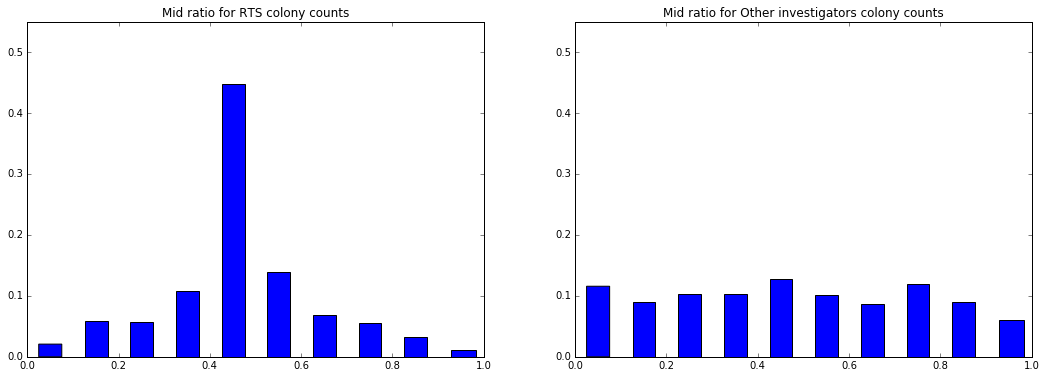

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

tmp1 = [(x[1] - x[0])*1.0/max(x[2] - x[0],1) for x in cleanData1]
tmp2 = [(x[1] - x[0])*1.0/max(x[2] - x[0],1) for x in cleanData2]
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
counts, bins, ignored = plt.hist(tmp1, [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01], 
                                 rwidth=0.5, weights=np.zeros_like(tmp1) + 1. / len(tmp1))
plt.ylim(0, .55)
plt.title('Mid ratio for RTS colony counts')
plt.subplot(1, 2, 2)
counts, bins, ignored = plt.hist(tmp2, [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01],
                                 rwidth=0.5, weights=np.zeros_like(tmp2) + 1. / len(tmp2))
plt.ylim(0, .55)
plt.title('Mid ratio for Other investigators colony counts')
plt.show()
# print(bins)
# print(counts)

<a id = 'Poisson_test'></a>
# Poisson test

In [81]:
def simulate_triple(lams):
    simu_triples = [np.random.poisson(lam=i, size=3).tolist() for i in lams]
    # var_triple = [np.var(triple) for triple in simu_triples]
    # mean_triple =  [np.mean(triple) for triple in simu_triples]
    return simu_triples

In [93]:
def regress(x, y):
    '''
    regress y = alpha * x with no intercept
    Inputs:
      x: list/array covariate
      y: list/array response
    Outputs:
      alpha: slope
    '''
    import numpy as np
    a = np.sum([i**2 for i in x])
    b = np.sum([i*j for i, j in zip(x, y)])
    return b/a

In [108]:
def TriplePoissonTest(data, verbose = True, plot = True):
    '''
     Test whether given list of triples come from Poisson test
     Inputs:
       data: list of triples, integer
       verbose: boolean whether to print information
       plot: boolean whether to plot the figure
     Outputs:
       prob: probability whether the null hypothesis that triples are from poisson holds for this specific test.
    '''
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    sampleMean = [np.mean(x) for x in data]
    sampleVar  = [np.var(x)*3/2 for x in data]
    maxMean = np.max(sampleMean)
    minMean = np.min(sampleMean)
    slope = regress(sampleMean, sampleVar)
    if plot: 
        plt.figure(figsize=(18, 10)) # set figure size
        plt.subplot(3, 7, 1)
        plt.scatter(sampleMean, sampleVar)
        plt.xlim(minMean, maxMean)
        plt.ylim(minMean, maxMean*2)
        plt.plot([minMean, maxMean], [slope * minMean, slope * maxMean])
        plt.title('empirical')
        # plt.show()
    replicate = 20
    slopeList = []
    for i in range(replicate):
        simu = simulate_triple(random.sample(sampleMean, len(data)))
        sampleMean = [np.mean(x) for x in simu]
        sampleVar  = [np.var(x)*3/2 for x in simu]
        maxMean = np.max(sampleMean)
        minMean = np.min(sampleMean)
        slopeList.append(regress(sampleMean, sampleVar))
        if plot: 
            plt.subplot(3, 7, i + 2)
            plt.scatter(sampleMean, sampleVar)
            plt.xlim(minMean, maxMean)
            plt.ylim(minMean, maxMean*2)
            plt.plot([minMean, maxMean], [minMean, maxMean])
            plt.title('simulated ' + str(i))
    plt.show()
    if verbose: print(sum([i < slope for i in slopeList]), ' out of ', replicate, ' simulations have higer slopes than empirical.')
    # return sum([i < slope for i in slopeList])

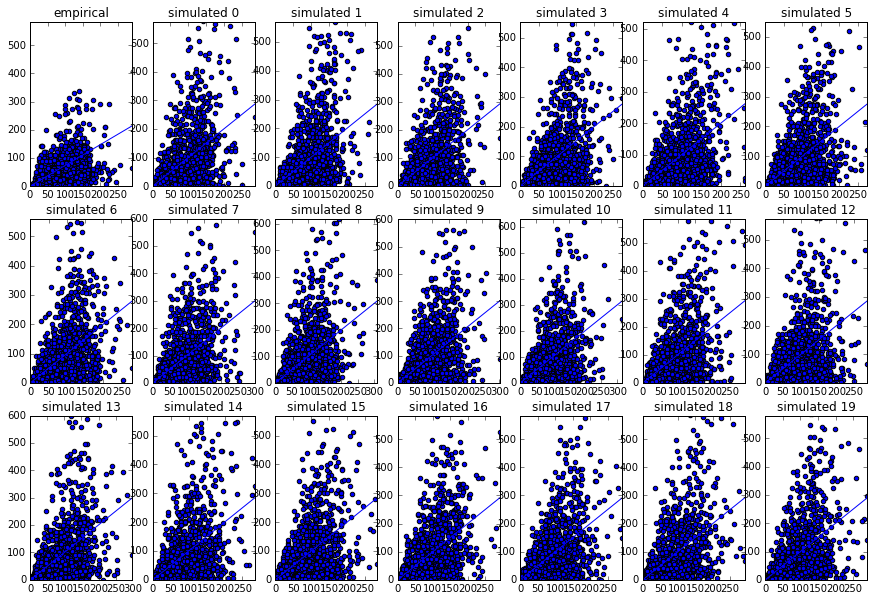

0  out of  20  simulations have higer slopes than empirical.


In [107]:
TriplePoissonTest(cleanData1)